In [ ]:
!pip install torch transformers pillow opencv-python easyocr scikit-learn matplotlib seaborn pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.1/292.1 kB 25.3 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
import re
import cv2
import copy
import random
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader,WeightedRandomSampler
from torchvision import transforms
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,classification_report,confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image,ImageEnhance,ImageFilter,ImageFile
import easyocr
from transformers import AutoTokenizer,AutoModel,ViTFeatureExtractor,ViTModel,pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
import string
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# Modify these paths to your own
ZIP_DIR = '/content/drive/MyDrive/Dissertation/images.zip'
UNZIP_IMAGE_DIR = '/content/drive/MyDrive/Dissertation/images'
IMAGE_DIR = "/content/drive/MyDrive/Dissertation/images"
CSV_FILE = "/content/drive/MyDrive/Dissertation/labels.csv"
OUTPUT_DIR = "/content/drive/MyDrive/Dissertation/"
CACHE_DIR = "/content/drive/MyDrive/Dissertation/cache"
os.makedirs(CACHE_DIR,exist_ok=True)

Mounted at /content/drive
使用设备: cuda


images already unzipped
Original dataset: 6992
Existing image files: 6992
Data distribution:
  Train dataset: 5593 
  Validation dataset: 699 
  Test dataset: 700 

Train Category distribution:
  very_negative: 121
  negative: 384
  neutral: 1761
  positive: 2501
  very_positive: 826

Val Category distribution:
  very_negative: 15
  negative: 48
  neutral: 220
  positive: 313
  very_positive: 103

Test Category distribution:
  very_negative: 15
  negative: 48
  neutral: 220
  positive: 313
  very_positive: 104
EasyOCR successful
Pre-extract all image text...


Extract text: 100%|██████████| 5593/5593 [21:54<00:00,  4.25piece/s]


Text extraction completed! Success rate: 5556/5593 (99.3%)
EasyOCR successful
Pre-extract all image text...


Extract text: 100%|██████████| 699/699 [02:41<00:00,  4.32piece/s]


Text extraction completed! Success rate: 695/699 (99.4%)
EasyOCR successful
Pre-extract all image text...


Extract text: 100%|██████████| 700/700 [02:39<00:00,  4.40piece/s]


Text extraction completed! Success rate: 695/700 (99.3%)
  Raw category counts: [ 121  384 1761 2501  826]
  Minority classes: [0 1 4]
  Enhanced weight: [3.3961901  1.07015366 0.02121413 0.01493726 0.49750485]
  Minority oversampling factor: 11
Sampling strategy:
  every epoch samples number: 11186
  number of Minority category: 1331
  Expected number of samples per epoch for the minority category: ~660


Some weights of RobertaModel were not initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model parameters: 173,408,278 Total: 62,786,326 can be trainable

 Start testing
Category distribution statistics:
Category 0 (very_negative): 3404
Category 1 (negative): 3545
Category 2 (neutral): 309
Category 3 (positive): 302
Category 4 (very_positive): 3626
CBFocalLoss
  Number of samples per class: [3404 3545  309  302 3626]
  CB Weight: [0.4149089  0.40657382 1.87420544 1.90230482 0.40200702]
  Alpha weight: [0.08871915 0.08519041 0.97734628 1.         0.08328737]

Epoch 1/15


Epoch 1 training: 100%|██████████| 700/700 [03:29<00:00,  3.34batch/s, Loss=1.6173, LR=2.00e-07]



Validation...


Validation: 100%|██████████| 44/44 [00:07<00:00,  5.94batch/s]



Validation set classification report:
               precision    recall  f1-score   support

very_negative     0.0106    0.0667    0.0183        15
     negative     0.0652    0.0625    0.0638        48
      neutral     0.3429    0.1636    0.2215       220
     positive     0.4306    0.5847    0.4959       313
very_positive     0.1379    0.0388    0.0606       103

     accuracy                         0.3247       699
    macro avg     0.1974    0.1833    0.1721       699
 weighted avg     0.3258    0.3247    0.3055       699


Epoch 1 results:
Training loss: 1.7256
Training F1 score: 0.1843
Training Macro F1 score: 0.1352
Validation loss: 1.0641
Validation accuracy: 0.3247 (32.47%)
Validation F1 score: 0.3055
Validation Macro F1 score: 0.1721
IMPROVING ★

Epoch 2/15


Epoch 2 training: 100%|██████████| 700/700 [03:40<00:00,  3.18batch/s, Loss=1.5894, LR=2.00e-07]



Validation...


Validation: 100%|██████████| 44/44 [00:07<00:00,  5.95batch/s]



Validation set classification report:
               precision    recall  f1-score   support

very_negative     0.0101    0.0667    0.0175        15
     negative     0.1250    0.0625    0.0833        48
      neutral     0.3295    0.3955    0.3595       220
     positive     0.4132    0.3802    0.3960       313
very_positive     0.2083    0.0485    0.0787       103

     accuracy                         0.3076       699
    macro avg     0.2172    0.1907    0.1870       699
 weighted avg     0.3282    0.3076    0.3082       699


Epoch 2 results:
Training loss: 1.6725
Training F1 score: 0.1797
Training Macro F1 score: 0.1347
Validation loss: 1.0429
Validation accuracy: 0.3076 (30.76%)
Validation F1 score: 0.3082
Validation Macro F1 score: 0.1870
IMPROVING ★

Epoch 3/15


Epoch 3 training: 100%|██████████| 700/700 [03:40<00:00,  3.17batch/s, Loss=1.6538, LR=2.00e-07]



Validation...


Validation: 100%|██████████| 44/44 [00:07<00:00,  5.92batch/s]



Validation set classification report:
               precision    recall  f1-score   support

very_negative     0.0133    0.2000    0.0250        15
     negative     0.0000    0.0000    0.0000        48
      neutral     0.3273    0.3273    0.3273       220
     positive     0.4022    0.2300    0.2927       313
very_positive     0.1957    0.0874    0.1208       103

     accuracy                         0.2232       699
    macro avg     0.1877    0.1689    0.1532       699
 weighted avg     0.3122    0.2232    0.2524       699


Epoch 3 results:
Training loss: 1.6226
Training F1 score: 0.1932
Training Macro F1 score: 0.1407
Validation loss: 1.2088
Validation accuracy: 0.2232 (22.32%)
Validation F1 score: 0.2524
Validation Macro F1 score: 0.1532
did not improve (1/6)

Epoch 4/15


Epoch 4 training: 100%|██████████| 700/700 [03:30<00:00,  3.33batch/s, Loss=1.4255, LR=2.00e-07]



Validation...


Validation: 100%|██████████| 44/44 [00:07<00:00,  5.92batch/s]



Validation set classification report:
               precision    recall  f1-score   support

very_negative     0.0226    0.6000    0.0436        15
     negative     0.1200    0.0625    0.0822        48
      neutral     0.3069    0.2636    0.2836       220
     positive     0.5000    0.0767    0.1330       313
very_positive     0.2051    0.0777    0.1127       103

     accuracy                         0.1459       699
    macro avg     0.2309    0.2161    0.1310       699
 weighted avg     0.3594    0.1459    0.1720       699


Epoch 4 results:
Training loss: 1.5792
Training F1 score: 0.2063
Training Macro F1 score: 0.1513
Validation loss: 1.3579
Validation accuracy: 0.1459 (14.59%)
Validation F1 score: 0.1720
Validation Macro F1 score: 0.1310
did not improve (2/6)

Epoch 5/15


Epoch 5 training: 100%|██████████| 700/700 [03:30<00:00,  3.33batch/s, Loss=1.4550, LR=2.00e-07]



Validation...


Validation: 100%|██████████| 44/44 [00:07<00:00,  5.94batch/s]



Validation set classification report:
               precision    recall  f1-score   support

very_negative     0.0261    0.5333    0.0497        15
     negative     0.0556    0.0208    0.0303        48
      neutral     0.3188    0.4318    0.3668       220
     positive     0.5238    0.0703    0.1239       313
very_positive     0.0882    0.0291    0.0438       103

     accuracy                         0.1845       699
    macro avg     0.2025    0.2171    0.1229       699
 weighted avg     0.3523    0.1845    0.1805       699


Epoch 5 results:
Training loss: 1.5452
Training F1 score: 0.1895
Training Macro F1 score: 0.1419
Validation loss: 1.3139
Validation accuracy: 0.1845 (18.45%)
Validation F1 score: 0.1805
Validation Macro F1 score: 0.1229
did not improve (3/6)

Epoch 6/15


Epoch 6 training: 100%|██████████| 700/700 [03:30<00:00,  3.33batch/s, Loss=1.4085, LR=2.00e-07]



Validation...


Validation: 100%|██████████| 44/44 [00:07<00:00,  5.92batch/s]



Validation set classification report:
               precision    recall  f1-score   support

very_negative     0.0220    0.4667    0.0420        15
     negative     0.0303    0.0208    0.0247        48
      neutral     0.3066    0.2955    0.3009       220
     positive     0.4510    0.1470    0.2217       313
very_positive     0.1471    0.0485    0.0730       103

     accuracy                         0.1774       699
    macro avg     0.1914    0.1957    0.1325       699
 weighted avg     0.3227    0.1774    0.2073       699


Epoch 6 results:
Training loss: 1.5090
Training F1 score: 0.2105
Training Macro F1 score: 0.1522
Validation loss: 1.2617
Validation accuracy: 0.1774 (17.74%)
Validation F1 score: 0.2073
Validation Macro F1 score: 0.1325
did not improve (4/6)

Epoch 7/15


Epoch 7 training: 100%|██████████| 700/700 [03:30<00:00,  3.33batch/s, Loss=3.3759, LR=1.60e-07]



Validation...


Validation: 100%|██████████| 44/44 [00:07<00:00,  5.92batch/s]



Validation set classification report:
               precision    recall  f1-score   support

very_negative     0.0187    0.3333    0.0355        15
     negative     0.0877    0.1042    0.0952        48
      neutral     0.3416    0.3773    0.3585       220
     positive     0.4107    0.1470    0.2165       313
very_positive     0.2000    0.0388    0.0650       103

     accuracy                         0.2046       699
    macro avg     0.2117    0.2001    0.1541       699
 weighted avg     0.3273    0.2046    0.2267       699


Epoch 7 results:
Training loss: 1.4844
Training F1 score: 0.2010
Training Macro F1 score: 0.1485
Validation loss: 1.2581
Validation accuracy: 0.2046 (20.46%)
Validation F1 score: 0.2267
Validation Macro F1 score: 0.1541
did not improve (5/6)

Epoch 8/15


Epoch 8 training: 100%|██████████| 700/700 [03:30<00:00,  3.33batch/s, Loss=1.3069, LR=1.60e-07]



Validation...


Validation: 100%|██████████| 44/44 [00:07<00:00,  5.94batch/s]



Validation set classification report:
               precision    recall  f1-score   support

very_negative     0.0213    0.4667    0.0407        15
     negative     0.0577    0.0625    0.0600        48
      neutral     0.3333    0.2955    0.3133       220
     positive     0.4466    0.1470    0.2212       313
very_positive     0.1000    0.0194    0.0325       103

     accuracy                         0.1760       699
    macro avg     0.1918    0.1982    0.1335       699
 weighted avg     0.3240    0.1760    0.2074       699


Epoch 8 results:
Training loss: 1.4483
Training F1 score: 0.2158
Training Macro F1 score: 0.1572
Validation loss: 1.2734
Validation accuracy: 0.1760 (17.60%)
Validation F1 score: 0.2074
Validation Macro F1 score: 0.1335
did not improve (6/6)

 Early stop trigger based on Macro F1! Continuous 6 epoch does not improve

 saving path: /content/drive/MyDrive/Dissertation/training_results.csv

 Loading the best model for testing...
Start final testing


testing: 100%|██████████| 44/44 [00:07<00:00,  6.00batch/s]



=== Final test results ===
Test accuracy: 0.3386 (33.86%)
Test Weighted F1: 0.3106

 Detailed classification report of the test set:
               precision    recall  f1-score   support

very_negative     0.0000    0.0000    0.0000        15
     negative     0.0000    0.0000    0.0000        48
      neutral     0.2977    0.4045    0.3430       220
     positive     0.4273    0.4696    0.4475       313
very_positive     0.2000    0.0096    0.0183       104

     accuracy                         0.3386       700
    macro avg     0.1850    0.1768    0.1618       700
 weighted avg     0.3143    0.3386    0.3106       700

Test results saved to /content/drive/MyDrive/Dissertation/test_results.csv

 Generate interpretable visualizations...
Processing samples 1...
Image attention shape: torch.Size([1, 196])
Num patches: 196,Grid size: 14
Successfully generated 14x14 heatmap
Filtered tokens: 21 out of 24 valid tokens
save: /content/drive/MyDrive/Dissertation/enhanced_attention_visualizat

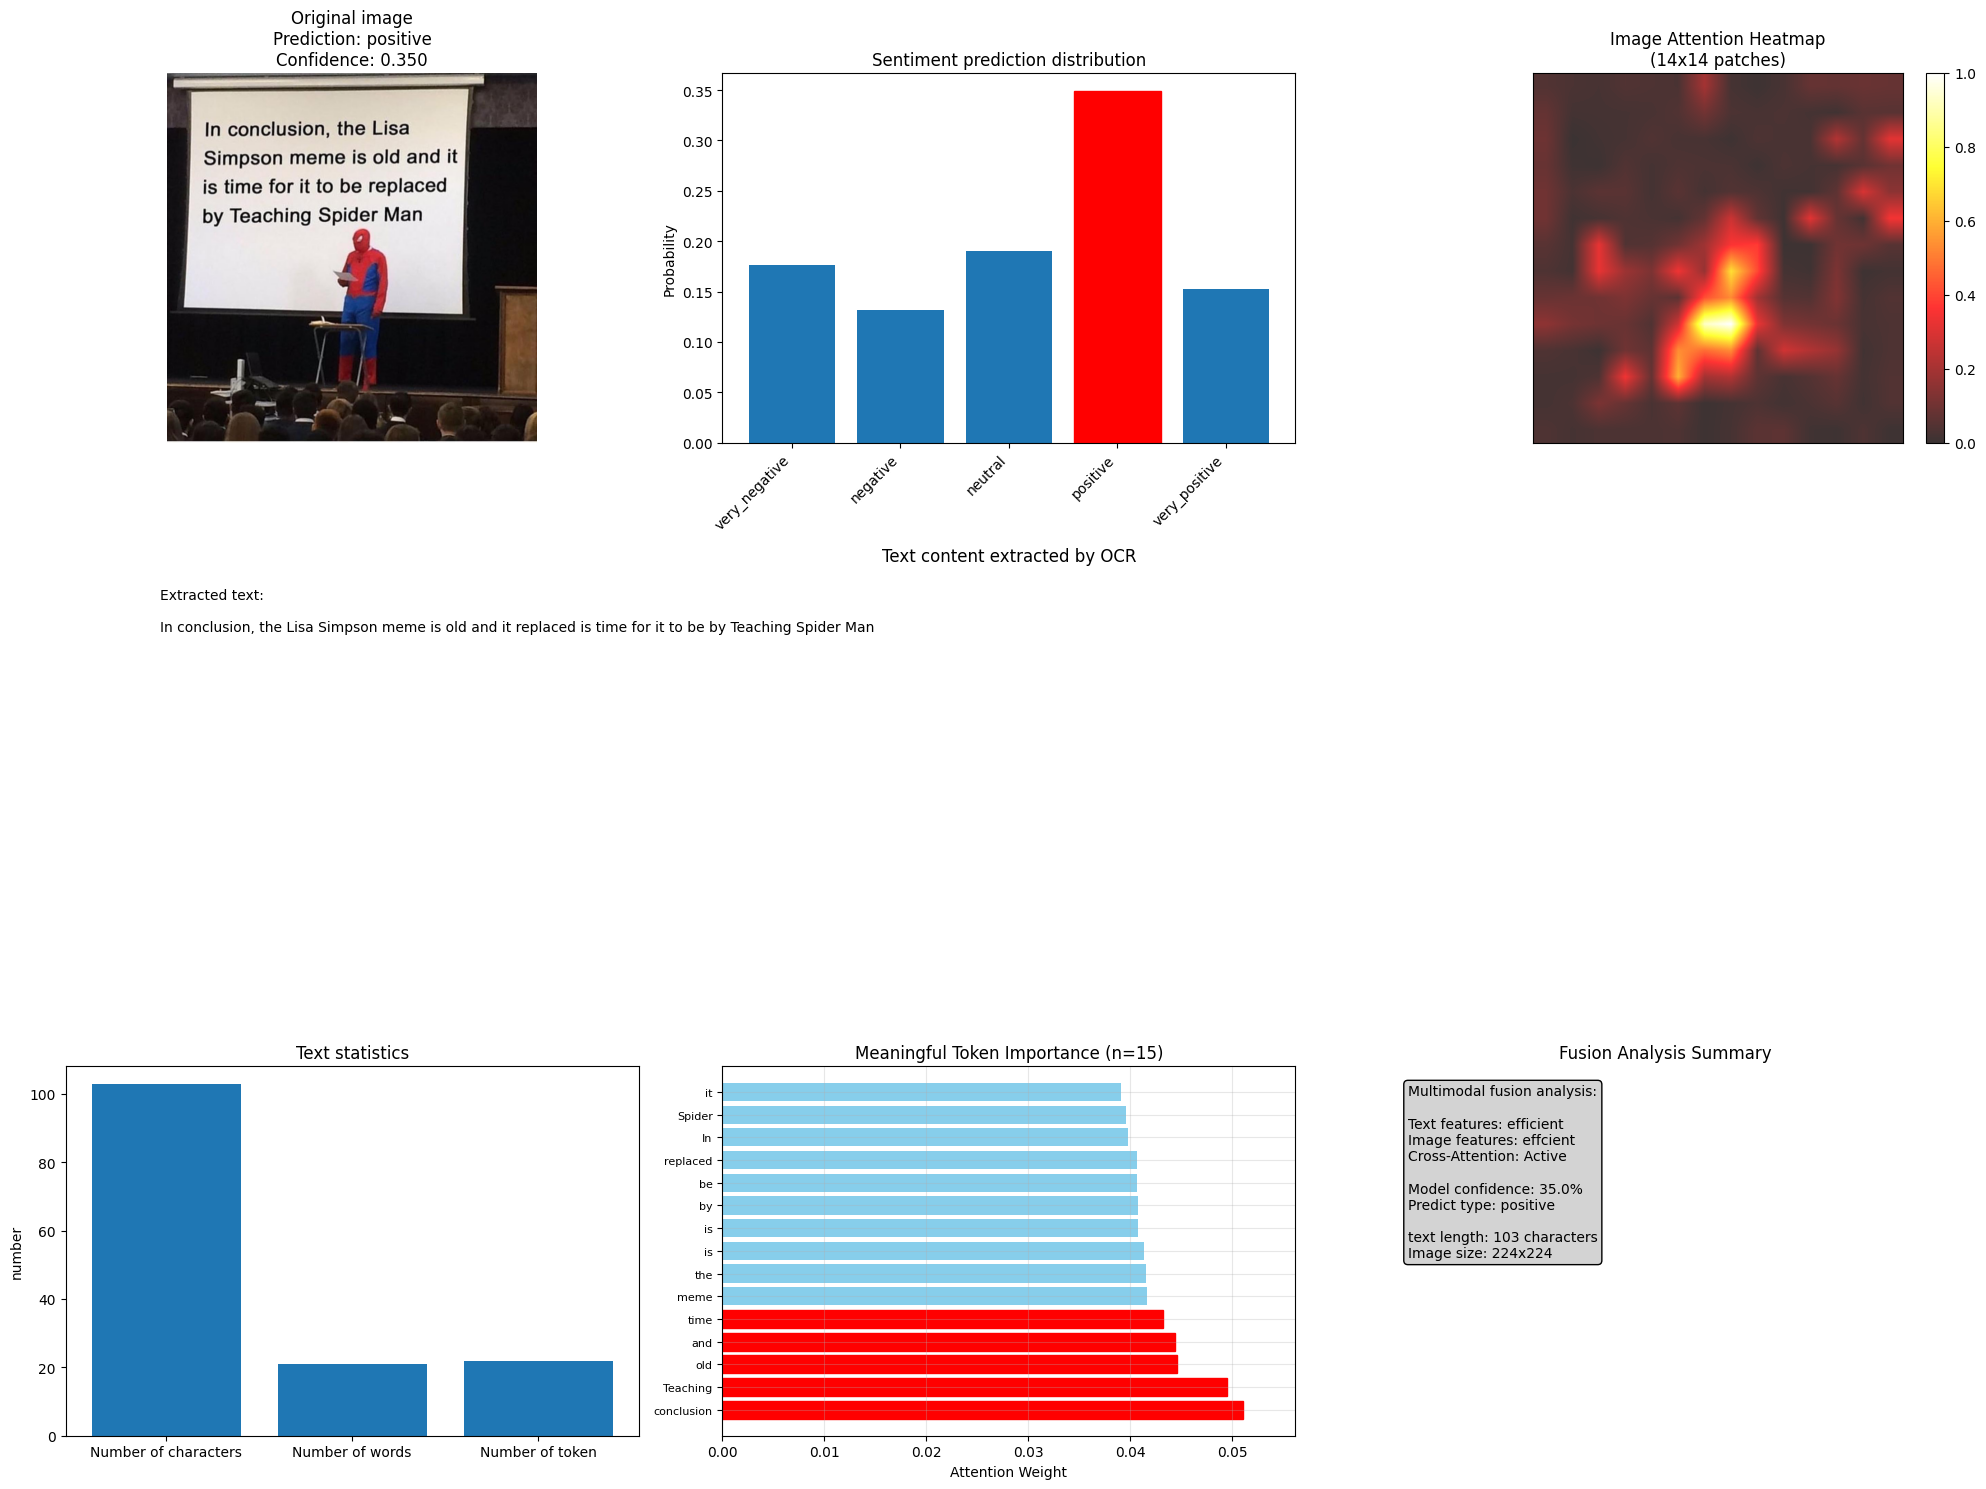

Processing samples 2...
Image attention shape: torch.Size([1, 196])
Num patches: 196,Grid size: 14
Successfully generated 14x14 heatmap
Filtered tokens: 12 out of 15 valid tokens
save: /content/drive/MyDrive/Dissertation/enhanced_attention_visualization_sample_2.png


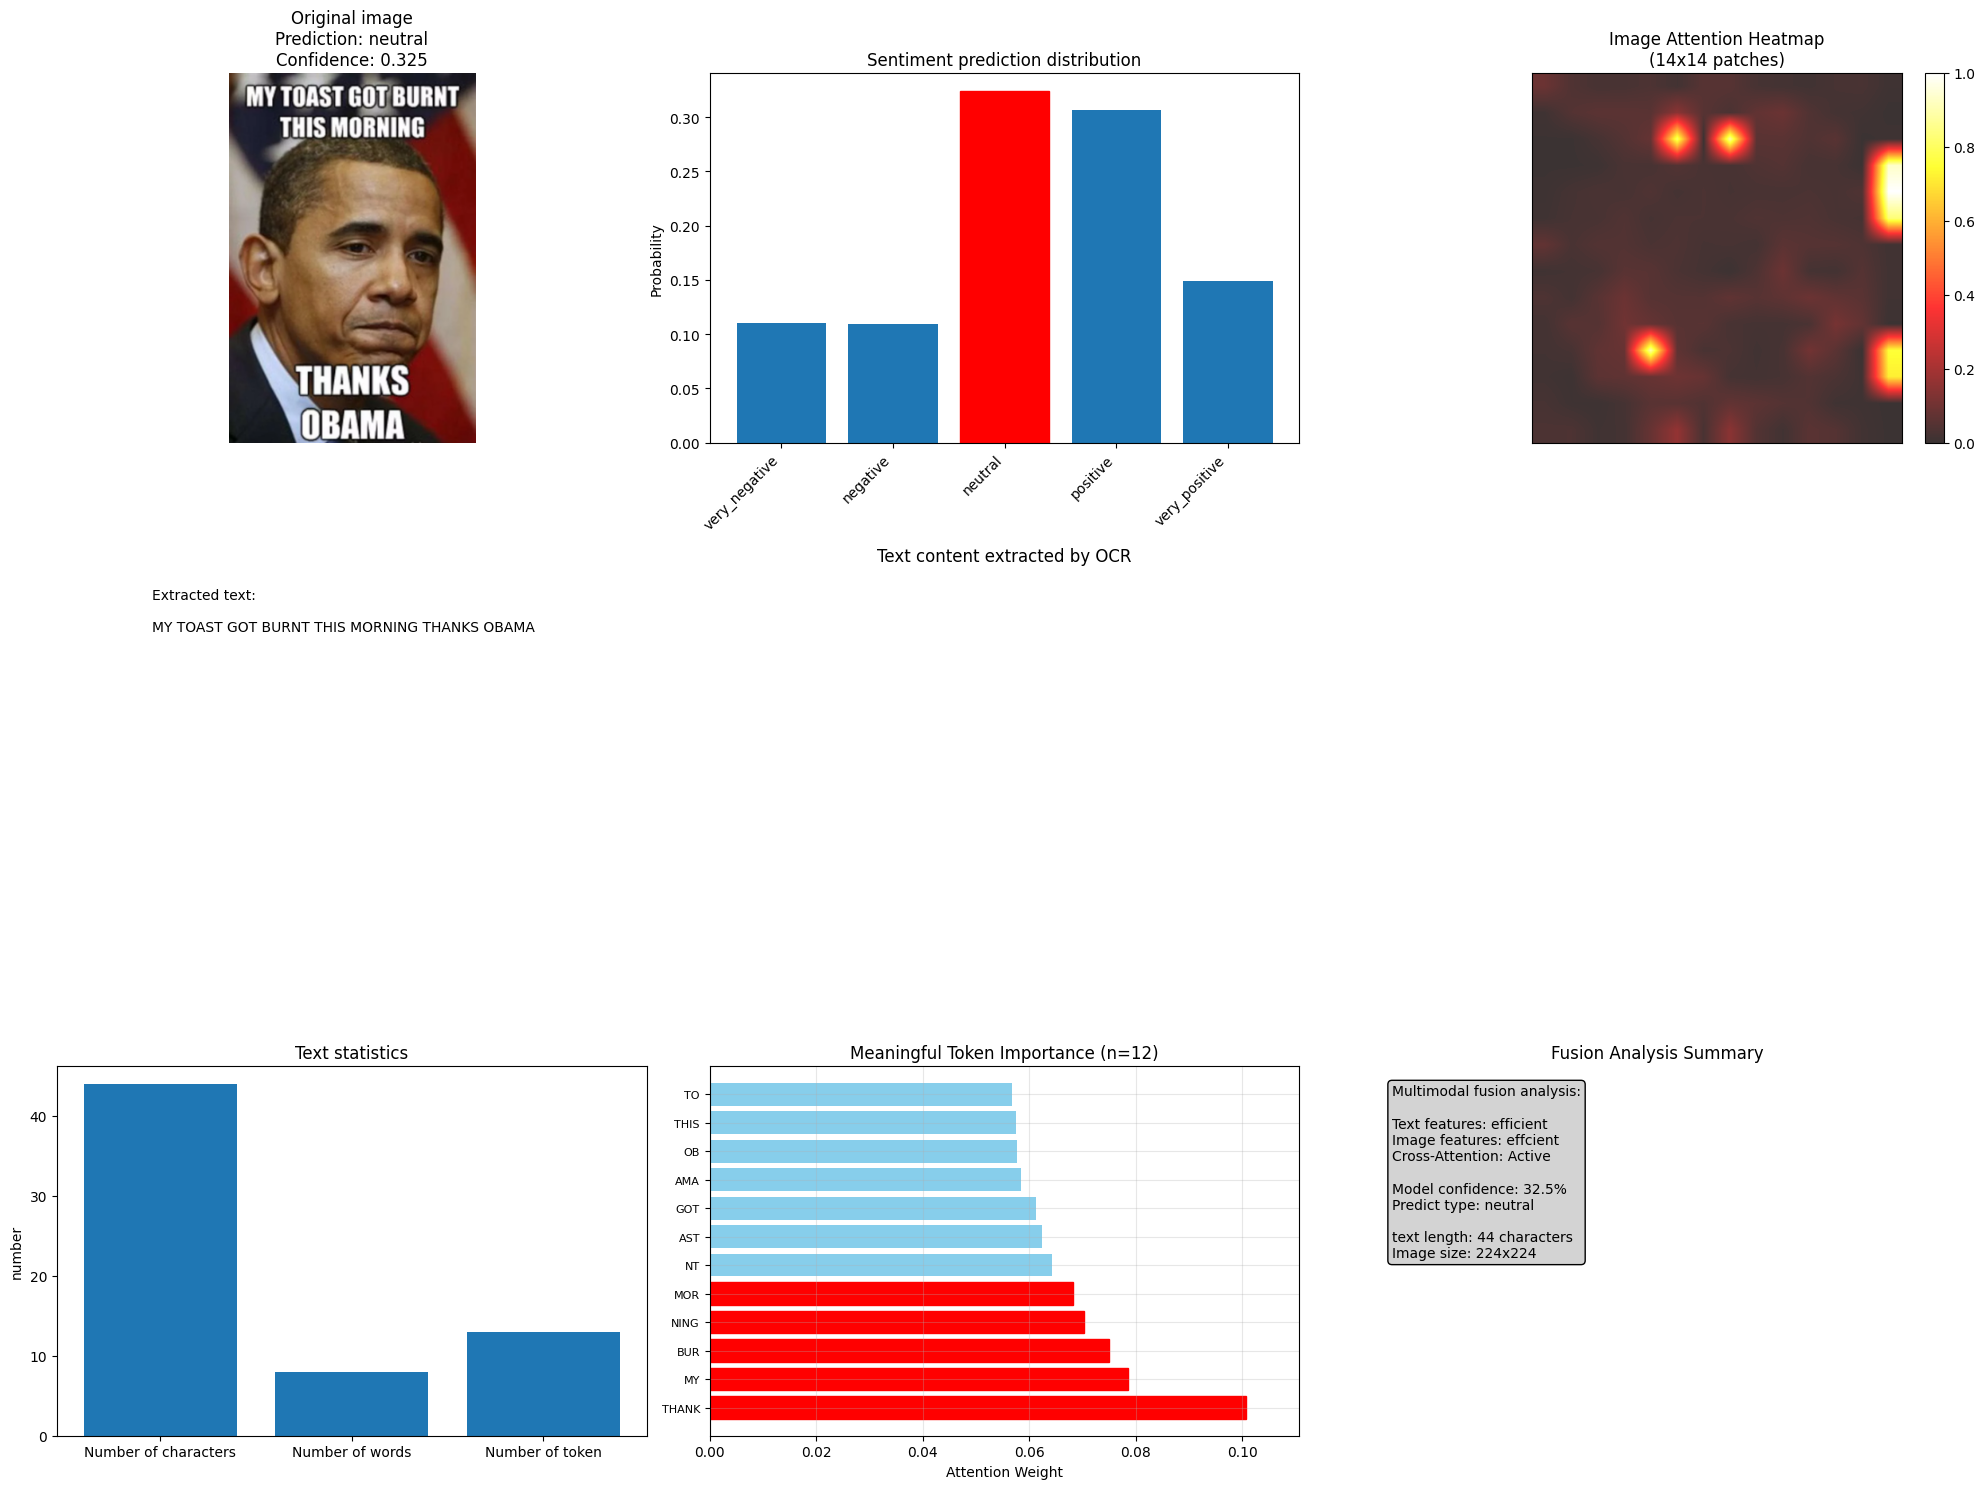

Processing samples 3...
Image attention shape: torch.Size([1, 196])
Num patches: 196,Grid size: 14
Successfully generated 14x14 heatmap
Filtered tokens: 19 out of 24 valid tokens
save: /content/drive/MyDrive/Dissertation/enhanced_attention_visualization_sample_3.png


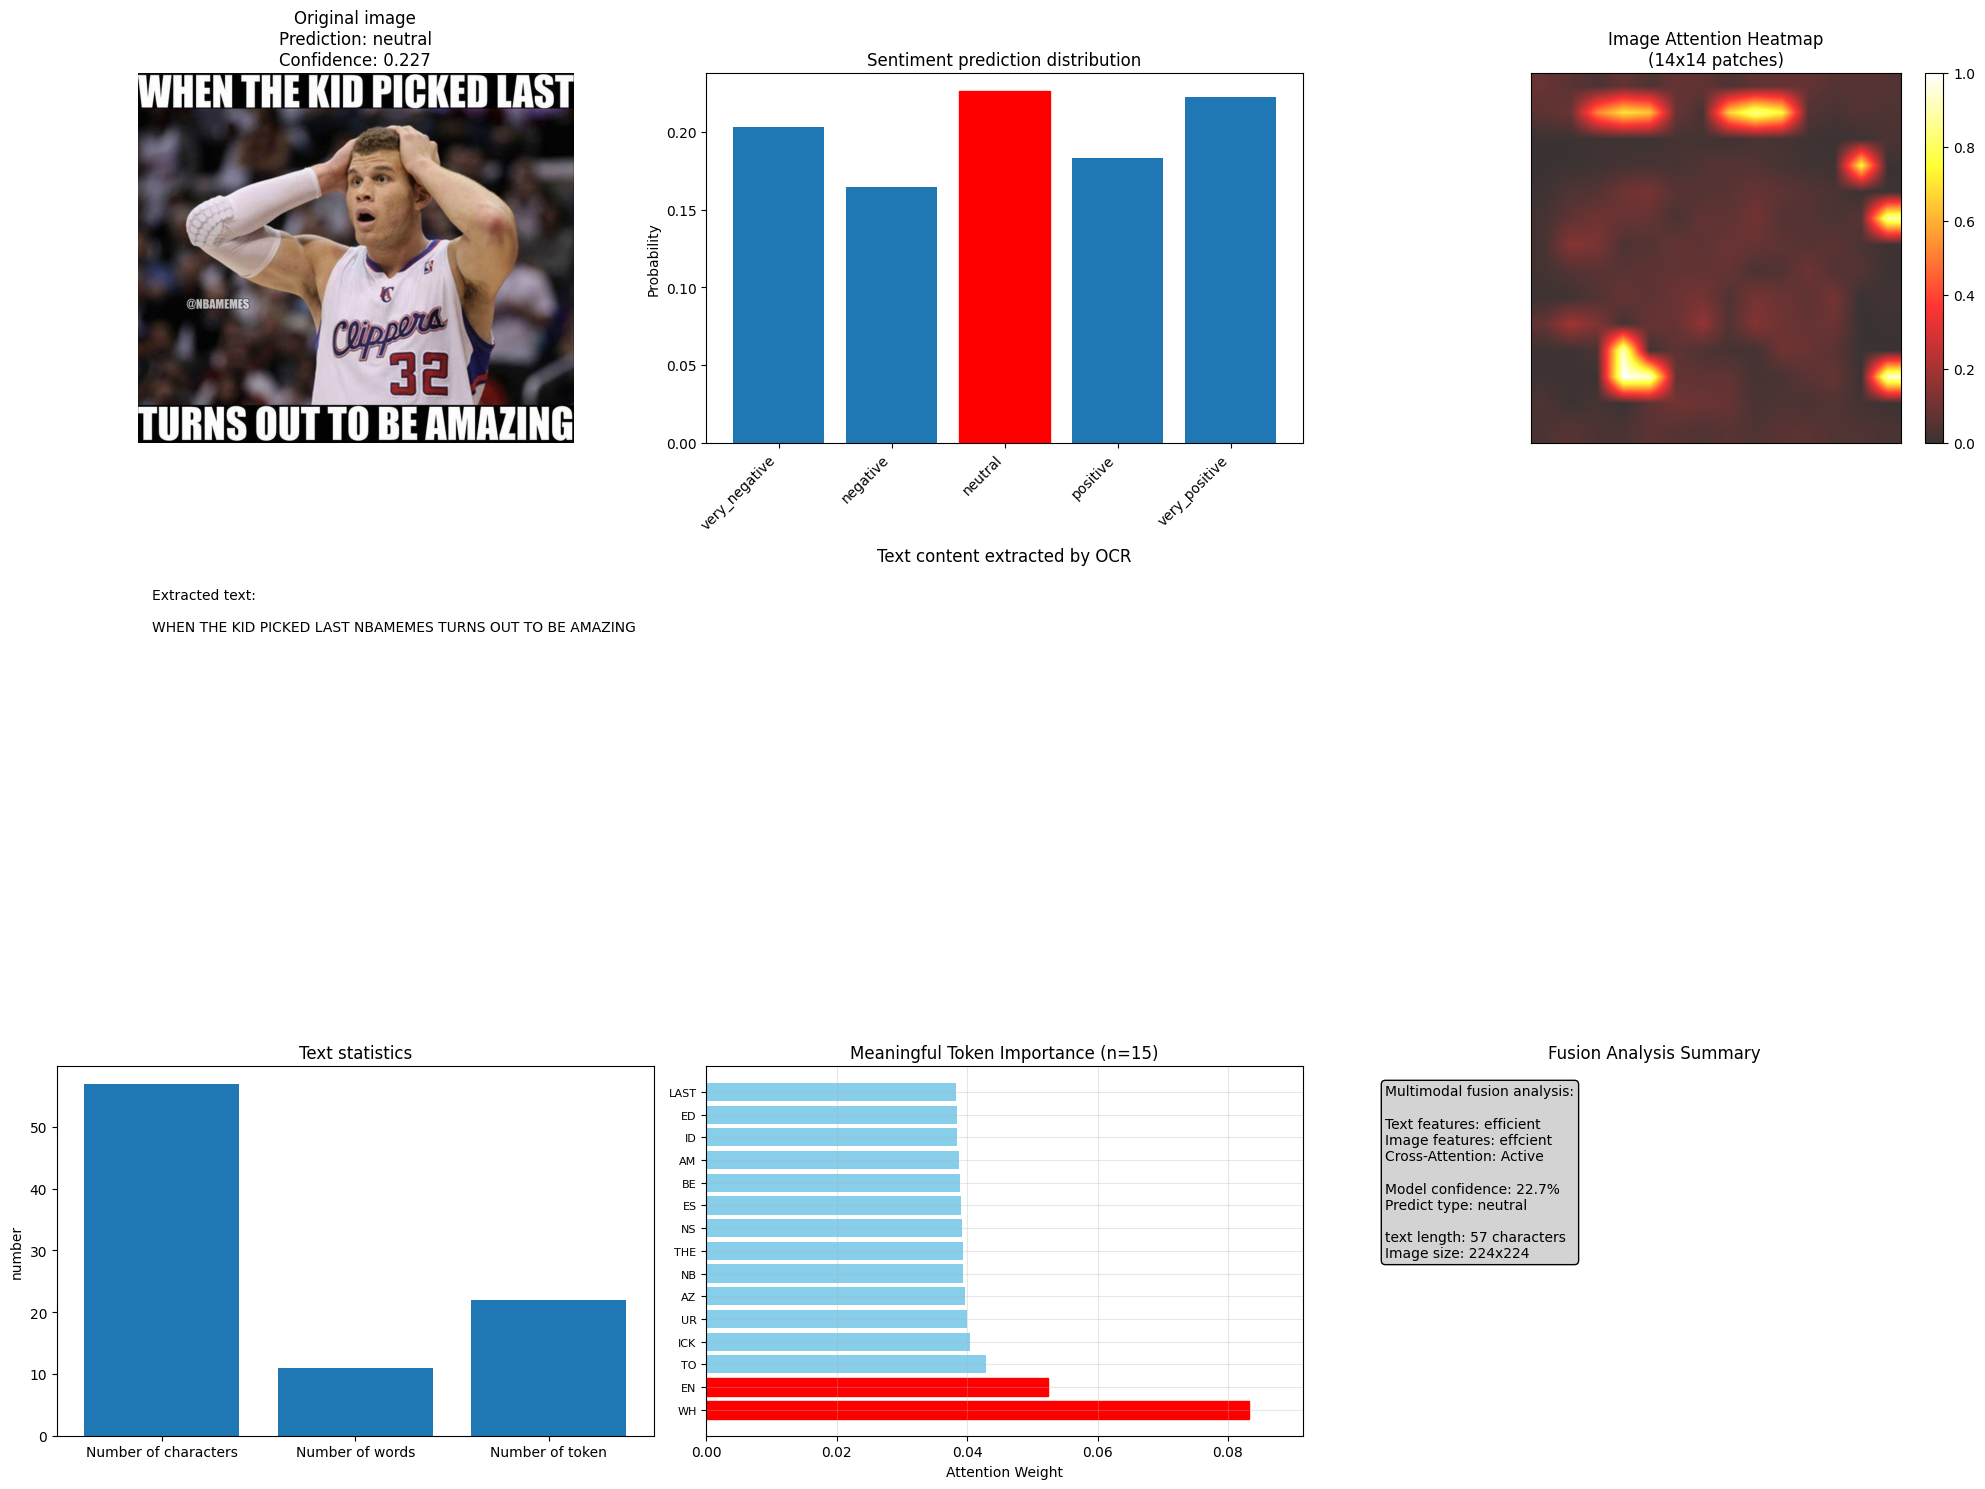

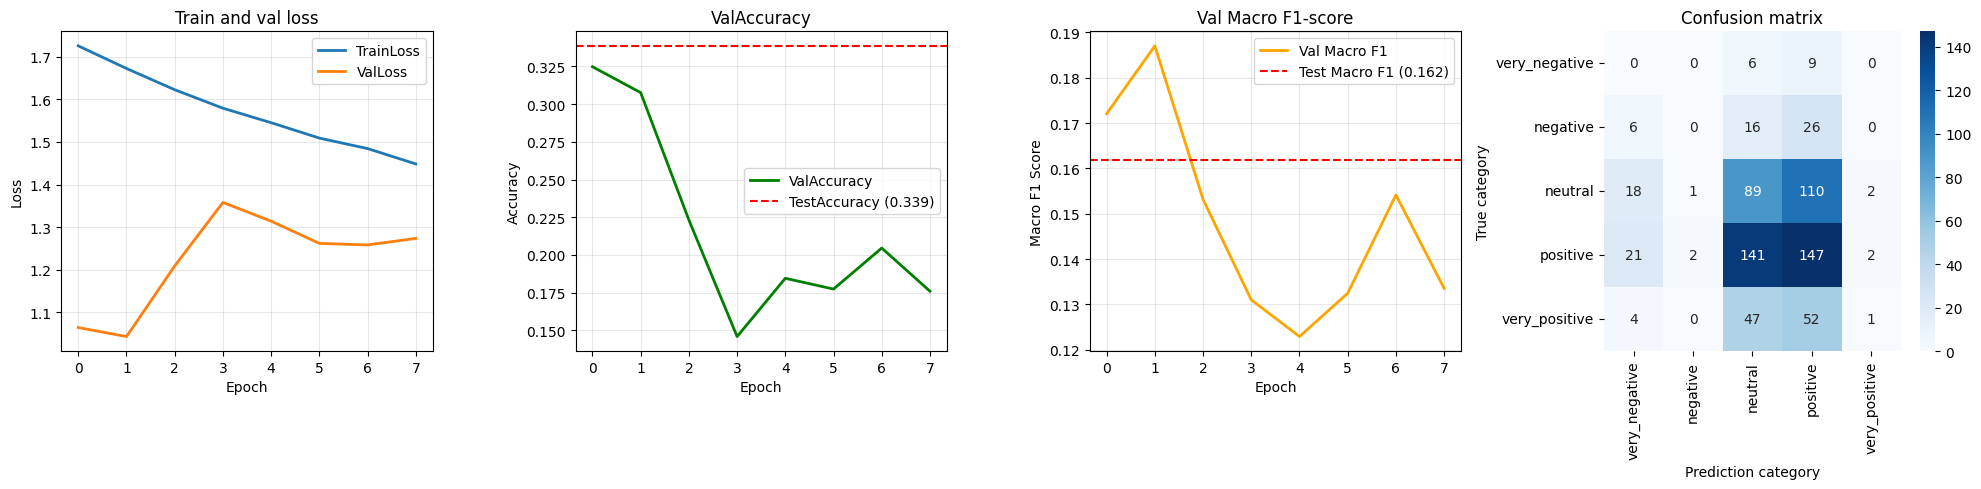

Best model: /content/drive/MyDrive/Dissertation/best_enhanced_meme_model.pth
Training CSV: /content/drive/MyDrive/Dissertation/training_results.csv
Tesing CSV: /content/drive/MyDrive/Dissertation/test_results.csv
Training image: /content/drive/MyDrive/Dissertation/enhanced_training_analysis.png
Visulization: /content/drive/MyDrive/Dissertation/enhanced_attention_visualization_sample_*.png
all models: /content/drive/MyDrive/Dissertation/model_summary.csv

 Training finished. Saving path: /content/drive/MyDrive/Dissertation/


In [ ]:
def unzip_images():
    if os.path.exists(UNZIP_IMAGE_DIR) and os.listdir(UNZIP_IMAGE_DIR):
        print("images already unzipped")
    else:
        !unzip $ZIP_DIR -d $OUTPUT_DIR
        image_paths=glob.glob(os.path.join(UNZIP_IMAGE_DIR,'*.jpg')) + glob.glob(os.path.join(UNZIP_IMAGE_DIR,'*.png'))+glob.glob(os.path.join(UNZIP_IMAGE_DIR,'*.jpeg'))
        # print(f"There are {len(image_paths)} images")

        ImageFile.LOAD_TRUNCATED_IMAGES = True
        Image.MAX_IMAGE_PIXELS = None

        for image in image_paths:
            image_name=os.path.basename(image)
            # print(image_name)
            img = Image.open(image)
            img.load()
            if image.lower().endswith(('.jpg','.jpeg')):
                if img.mode in ['RGBA','P','LA']:
                    if img.mode == 'RGBA':
                        background = Image.new('RGB',img.size,(255,255,255))
                        background.paste(img,mask=img.split()[-1])
                        img = background
                    else:
                        img = img.convert('RGB')
            img.save(image)

# Clean up extra characters
def clean_easyocr_text(text):
    if not text:
        return ""

    # Remove leading and trailing whitespace
    text = text.strip()
    # Only remove obvious noise characters
    text = re.sub(r'[^\w\s.,!?;:()\'-]',' ',text)
    # Clear space
    text = ' '.join(text.split())
    if len(text) < 2 or not any(c.isalpha() for c in text):
        return ""
    return text

# Extracting text from images using easyocr
def extract_text_with_easyocr(image_path,reader):
    results = reader.readtext(image_path)
    if not results:
        return ""

    # Returns the position of the text in the image sorted from top to bottom
    sorted_results = sorted(results,key=lambda x: x[0][0][1])
    # Collect high-confidence text
    texts = []
    for bbox,text,confidence in sorted_results:
        if confidence > 0.5:  # Collect high-confidence text
            cleaned_text = clean_easyocr_text(text)
            if cleaned_text and len(cleaned_text) > 1:
                texts.append(cleaned_text)
    return ' '.join(texts) if texts else ""

# Preprocessing images
def extract_with_preprocessing(image_path,reader):
    img = cv2.imread(image_path)
    if img is None:
        return ""

    # Enlarge the image
    height,width = img.shape[:2]
    if min(height,width) < 500:
        scale = 500 / min(height,width)
        new_width = int(width * scale)
        new_height = int(height * scale)
        img = cv2.resize(img,(new_width,new_height),interpolation=cv2.INTER_CUBIC)

    # Enhance contrast
    lab = cv2.cvtColor(img,cv2.COLOR_BGR2LAB)
    l,a,b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0,tileGridSize=(8,8))
    l = clahe.apply(l)
    enhanced = cv2.merge([l,a,b])
    enhanced = cv2.cvtColor(enhanced,cv2.COLOR_LAB2BGR)
    results = reader.readtext(enhanced)

    # results
    texts = []
    for bbox,text,confidence in results:
        if confidence > 0.3:
            cleaned_text = clean_easyocr_text(text)
            if cleaned_text and len(cleaned_text) > 1:
                texts.append(cleaned_text)

    if results:
        sorted_results = sorted(
            [(bbox,text,conf) for bbox,text,conf in results if conf > 0.3],
            key=lambda x: x[0][0][1]
        )
        texts = [clean_easyocr_text(text) for bbox,text,conf in sorted_results if clean_easyocr_text(text) and len(clean_easyocr_text(text)) > 1]

    return ' '.join(texts) if texts else ""

# Two ways to extract text
def extract_meme_text(image_path,reader):
    # 1. Using EasyOCR directly
    text1 = extract_text_with_easyocr(image_path,reader)
    # 2. Using EasyOCR after preprocessing
    text2 = extract_with_preprocessing(image_path,reader)
    # Choose better choice
    if len(text2) > len(text1) and len(text2) > 5:
        return text2
    elif len(text1) > 5:
        return text1
    else:
        return text2 if len(text2) > len(text1) else text1

# Processing multimodal datasets of images and text
class EnhancedMemeDataset(Dataset):
    # Pre-extract text from all images and cache it
    def __init__(self,image_paths,labels,tokenizer,feature_extractor,max_length=256):
        self.image_paths = image_paths
        self.labels = labels
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor
        self.max_length = max_length

        try:
            self.ocr_reader = easyocr.Reader(['en'],gpu=torch.cuda.is_available())
            print("EasyOCR successful")
        except Exception as e:
            print(f"EasyOCR error: {e}")
            raise

        print("Pre-extract all image text...")
        self.cached_texts = {}
        for i,path in enumerate(tqdm(image_paths,desc="Extract text",unit="piece")):
            self.cached_texts[path] = self.extract_text_from_image(path)

        success_count = sum(1 for text in self.cached_texts.values() if text and text not in ["[NO_TEXT_FOUND]","[EASYOCR_ERROR]"])
        print(f"Text extraction completed! Success rate: {success_count}/{len(image_paths)} ({success_count/len(image_paths)*100:.1f}%)")

    # Extract text from images
    def extract_text_from_image(self,image_path):
        extracted_text = extract_meme_text(image_path,self.ocr_reader)
        if extracted_text:
            extracted_text = extracted_text.replace('\n',' ').replace('\t',' ')
            extracted_text = ' '.join(extracted_text.split())

        return extracted_text.strip() if extracted_text and extracted_text.strip() else "[NO_TEXT_FOUND]"

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self,idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        # Get cached text
        text = self.cached_texts.get(image_path,"[NO_TEXT]")

        # Text enhancement, with a small probability of deleting some words to improve robustness
        try:
            if isinstance(text,str) and len(text.split()) > 3:
                if random.random() < 0.2:
                    words = text.split()
                    keep = []
                    for w in words:
                        if random.random() < 0.95:
                            keep.append(w)
                    new_text = ' '.join(keep).strip()
                    if len(new_text) >= 2:
                        text = new_text
        except Exception:
            pass

        # Text encoding
        text_encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        try:
            image = Image.open(image_path)
            if image.mode != 'RGB':
                image = image.convert('RGB')
            image = self.enhance_image(image)

            # Feature extraction
            image_encoding = self.feature_extractor(image,return_tensors='pt')

        except Exception as e:
            print(f"error {image_path}: {e}")
            # fallback a white picture
            try:
                image = Image.new('RGB',(224,224),color=(255,255,255))
                image_encoding = self.feature_extractor(image,return_tensors='pt')
            except Exception as e2:
                print(f"error {e2}")
                image_encoding = {'pixel_values': torch.zeros((3,224,224),dtype=torch.float32)}

        return {
            'text_input_ids': text_encoding['input_ids'].squeeze(),
            'text_attention_mask': text_encoding['attention_mask'].squeeze(),
            'image_pixel_values': image_encoding['pixel_values'].squeeze(),
            'label': torch.tensor(label,dtype=torch.long),
            'text': text,
            'image_path': image_path
        }

    # Image preprocessing enhancement
    def enhance_image(self,image):
        try:
            if image.mode != 'RGB':
                image = image.convert('RGB')

            transform_list = []
            # Random cropping, scaling, horizontal flipping, and color changes
            transform_list.append(transforms.RandomResizedCrop(224,scale=(0.8,1.0)))
            transform_list.append(transforms.RandomHorizontalFlip(p=0.5))
            transform_list.append(transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2,hue=0.02))
            transform = transforms.Compose(transform_list + [
                transforms.Resize((224,224)),
            ])

            pil_transformed = transform(image)
            pil_transformed = pil_transformed.filter(ImageFilter.UnsharpMask(radius=1,percent=120,threshold=1))
            return pil_transformed

        except Exception as e:
            print(f"Image enhancement failed,returning the original image: {e}")
            return image.convert('RGB') if image.mode != 'RGB' else image

# Text and images can draw attention to important information
class AdvancedCrossModalAttention(nn.Module):
    def __init__(self,text_dim,image_dim,hidden_dim=512,num_heads=8):
        super(AdvancedCrossModalAttention,self).__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads

        # Modality-aligned projection
        self.text_proj = nn.Sequential(
            nn.Linear(text_dim,hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.image_proj = nn.Sequential(
            nn.Linear(image_dim,hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Multi-head attention mechanism
        self.text_to_image_attn = nn.MultiheadAttention(
            hidden_dim,num_heads=num_heads,dropout=0.1,batch_first=True
        )
        self.image_to_text_attn = nn.MultiheadAttention(
            hidden_dim,num_heads=num_heads,dropout=0.1,batch_first=True
        )

        # Residual connections and layer normalization
        self.text_norm = nn.LayerNorm(hidden_dim)
        self.image_norm = nn.LayerNorm(hidden_dim)

        # Gating mechanism
        self.text_gate = nn.Sequential(
            nn.Linear(hidden_dim * 2,hidden_dim),
            nn.Dropout(0.3),
            nn.Sigmoid()
        )
        self.image_gate = nn.Sequential(
            nn.Linear(hidden_dim * 2,hidden_dim),
            nn.Dropout(0.3),
            nn.Sigmoid()
        )

    def forward(self,text_features,image_features):
        batch_size = text_features.size(0)

        # Feature Projection
        text_proj = self.text_proj(text_features)
        image_proj = self.image_proj(image_features)

        # Expanding dimensions
        text_proj = text_proj.unsqueeze(1)
        image_proj = image_proj.unsqueeze(1)

        # Cross-Attention
        text_attended,text_attn_weights = self.text_to_image_attn(
            text_proj,image_proj,image_proj
        )
        image_attended,image_attn_weights = self.image_to_text_attn(
            image_proj,text_proj,text_proj
        )

        # Residual Connection
        text_attended = self.text_norm(text_attended + text_proj)
        image_attended = self.image_norm(image_attended + image_proj)

        # Gated Fusion
        text_original = text_proj.squeeze(1)
        image_original = image_proj.squeeze(1)
        text_attended_flat = text_attended.squeeze(1)
        image_attended_flat = image_attended.squeeze(1)

        # Calculating gating weights
        text_gate_input = torch.cat([text_original,text_attended_flat],dim=-1)
        image_gate_input = torch.cat([image_original,image_attended_flat],dim=-1)

        text_gate_weight = self.text_gate(text_gate_input)
        image_gate_weight = self.image_gate(image_gate_input)

        text_final = text_gate_weight * text_attended_flat + (1 - text_gate_weight) * text_original
        image_final = image_gate_weight * image_attended_flat + (1 - image_gate_weight) * image_original

        return text_final,image_final,text_attn_weights,image_attn_weights


# Calculate the category distribution to ensure that all categories are included
def calculate_class_distribution(labels,num_classes=5):
    class_counts = np.bincount(labels,minlength=num_classes)
    samples_per_class = class_counts[:num_classes]
    print(f"Category distribution statistics:")
    emotion_labels = ['very_negative','negative','neutral','positive','very_positive']
    for i,count in enumerate(samples_per_class):
        print(f"Category {i} ({emotion_labels[i]}): {count}")

    return samples_per_class

# Loss function for dealing with class imbalance
class CBFocalLoss(nn.Module):
    def __init__(self,samples_per_class,num_classes,beta=0.99,gamma=2.5,alpha=None,reduction='mean'):
        super(CBFocalLoss,self).__init__()
        samples_per_class = np.maximum(samples_per_class,1)
        effective_num = 1.0 - np.power(beta,samples_per_class)
        weights = (1.0 - beta) / effective_num

        # Give more weight to the minority class
        min_samples = np.min(samples_per_class)
        max_samples = np.max(samples_per_class)
        ratio = max_samples / (samples_per_class + 1e-6)

        combined_weights = weights * (ratio ** 0.5)
        combined_weights[2] *= 1.3
        combined_weights[3] *= 1.3
        combined_weights = combined_weights / np.sum(combined_weights) * num_classes

        self.class_weights = torch.tensor(combined_weights,dtype=torch.float32)
        self.num_classes = num_classes
        self.gamma = gamma
        self.reduction = reduction

        # Further enhance the minority class
        if alpha is None:
            inv_freq = 1.0 / (samples_per_class + 1e-6)
            alpha = inv_freq / inv_freq.sum()
            alpha = alpha / alpha.max()

        self.alpha = torch.tensor(alpha,dtype=torch.float32)

        print(f"CBFocalLoss")
        print(f"  Number of samples per class: {samples_per_class}")
        print(f"  CB Weight: {combined_weights}")
        print(f"  Alpha weight: {alpha}")

    def forward(self,logits,labels):
        device = logits.device
        weights = self.class_weights.to(device)
        alpha = self.alpha.to(device)

        # Calculating cross entropy
        log_probs = F.log_softmax(logits,dim=1)
        ce_loss = F.nll_loss(log_probs,labels,reduction='none')
        probs = torch.exp(log_probs)
        pt = probs.gather(1,labels.unsqueeze(1)).squeeze(1)
        pt = torch.clamp(pt,min=1e-7,max=1.0)

        focal_term = (1 - pt) ** self.gamma
        alpha_t = alpha[labels]
        cb_weights = weights[labels]

        loss = alpha_t * cb_weights * focal_term * ce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

# Create a balancer to improve minority sampling
def create_balanced_sampler(labels,minority_oversample_factor=11):
    labels = np.array(labels)
    class_counts = np.bincount(labels,minlength=5)

    # recogonize minority classes
    minority_threshold = 900
    minority_classes = np.where(class_counts < minority_threshold)[0]
    base_weights = 1.0 / (class_counts + 1e-6)

    # Give extra weight to minority classes
    enhanced_weights = base_weights.copy()
    for cls_idx in minority_classes:
        enhanced_weights[cls_idx] *= minority_oversample_factor

    enhanced_weights = enhanced_weights / enhanced_weights.sum() * len(enhanced_weights)

    # Assign weights to each sample
    sample_weights = [enhanced_weights[label] for label in labels]

    print(f"  Raw category counts: {class_counts}")
    print(f"  Minority classes: {minority_classes}")
    print(f"  Enhanced weight: {enhanced_weights}")
    print(f"  Minority oversampling factor: {minority_oversample_factor}")

    return sample_weights

# Fusion of text and image information for sentiment classification
class EnhancedMultiModalEmotionClassifier(nn.Module):
    def __init__(self,num_classes=5,hidden_dim=256):
        super(EnhancedMultiModalEmotionClassifier,self).__init__()
        # Two Text Encoder
        emotion_model_name = 'j-hartmann/emotion-english-distilroberta-base'
        try:
            self.text_encoder = AutoModel.from_pretrained(emotion_model_name)
            self.tokenizer_type = 'emotion-specific'
        except:
            self.text_encoder = AutoModel.from_pretrained('roberta-base')
            self.tokenizer_type = 'roberta'
        self.text_dim = self.text_encoder.config.hidden_size

        # Image Encoder
        self.image_encoder = ViTModel.from_pretrained('google/vit-base-patch16-224')
        self.image_dim = self.image_encoder.config.hidden_size
        self._freeze_more_layers()

        # Cross-Attention
        self.cross_modal_attention = AdvancedCrossModalAttention(
            self.text_dim,self.image_dim,hidden_dim
        )

        # fusion
        self.fusion_network = nn.Sequential(
            nn.Linear(hidden_dim * 2,hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(hidden_dim,hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.4),
        )

        self.classifier_head1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(hidden_dim // 2,hidden_dim // 4),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 4,num_classes)
        )

        self.classifier_head2 = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(hidden_dim // 2,num_classes)
        )

        # Fusion weight
        self.head_fusion = nn.Sequential(
            nn.Linear(hidden_dim // 2,2),
            nn.Softmax(dim=-1)
        )

        self.text_aux_classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(hidden_dim,hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2,num_classes)
        )
        self.image_aux_classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(hidden_dim,hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2,num_classes)
        )
        self._init_weights()

    def _init_weights(self):
        for module in [self.fusion_network,self.classifier_head1,self.classifier_head2,self.text_aux_classifier,self.image_aux_classifier]:
            for m in module.modules():
                if isinstance(m,nn.Linear):
                    nn.init.xavier_uniform_(m.weight)
                    if m.bias is not None:
                        nn.init.constant_(m.bias,0)
    # Freeze the first 6 layers of the text encoder, preventing overfitting
    def _freeze_more_layers(self):
        for param in self.text_encoder.embeddings.parameters():
            param.requires_grad = False

        if hasattr(self.text_encoder,'encoder'):
            total_layers = len(self.text_encoder.encoder.layer)
            freeze_layers = min(8,max(total_layers - 4,0))
            for layer in self.text_encoder.encoder.layer[:freeze_layers]:
                for param in layer.parameters():
                    param.requires_grad = False

        # Freeze the first 8 layers of the text encoder
        if hasattr(self.image_encoder,'embeddings'):
            for param in self.image_encoder.embeddings.parameters():
                param.requires_grad = False

        if hasattr(self.image_encoder,'encoder'):
            total_layers = len(self.image_encoder.encoder.layer)
            freeze_layers = min(8,max(total_layers - 4,0))
            for layer in self.image_encoder.encoder.layer[:freeze_layers]:
                for param in layer.parameters():
                    param.requires_grad = False
    # Forward propagation, extracting text and image features, applying cross attention, fusing features and outputting classification results
    def forward(self,text_input_ids,text_attention_mask,image_pixel_values,return_aux=False):
        if self.tokenizer_type == 'roberta':
            text_input_ids = text_input_ids.masked_fill(text_input_ids == 1,0)

        text_outputs = self.text_encoder(
            input_ids=text_input_ids,
            attention_mask=text_attention_mask,
            output_attentions=True
        )

        text_embeddings = text_outputs.last_hidden_state
        text_mask = text_attention_mask.unsqueeze(-1).expand(text_embeddings.size()).float()
        text_features = (text_embeddings * text_mask).sum(1) / text_mask.sum(1)

        text_attentions = text_outputs.attentions
        if text_attentions and len(text_attentions) > 0:
            last_layer_attention = text_attentions[-1]

            # Using CLS token attention method
            avg_attention = last_layer_attention.mean(dim=1)
            cls_attention = avg_attention[:,0,:]

            # Apply attention mask to filter padding
            masked_attention = cls_attention * text_attention_mask.float()

            # Enhance contrast
            for i in range(masked_attention.size(0)):
                valid_positions = text_attention_mask[i].bool()
                if valid_positions.sum() > 1:
                    valid_attn = masked_attention[i][valid_positions]
                    if valid_attn.max() > valid_attn.min():
                        enhanced_attn = torch.softmax(valid_attn * 2.5,dim=0)
                        masked_attention[i][valid_positions] = enhanced_attn
            text_attn_weights = masked_attention
        else:
            text_attn_weights = None

        # Image encoding
        image_outputs = self.image_encoder(pixel_values=image_pixel_values,output_attentions=True)
        image_features = image_outputs.last_hidden_state[:,0]

        image_attentions = image_outputs.attentions
        if image_attentions and len(image_attentions) > 0:
            last_layer_attention = image_attentions[-1]
            # print(f"Image attention raw shape: {last_layer_attention.shape}")

            if len(last_layer_attention.shape) == 4 and last_layer_attention.shape[2] > 1:
                # Take the attention of CLS token (patch 0) to all other patches
                avg_attention = last_layer_attention.mean(dim=1)
                # Get CLS attention to other patches: [batch,patches,patches] -> [batch,patches-1]
                image_attn_weights = avg_attention[:,0,1:]  # Remove CLS's attention from itself
                # print(f"Image attention processed shape: {image_attn_weights.shape}")

                if image_attn_weights.shape[1] == 0:
                    # print("Warning: No patches available after removing CLS token")
                    image_attn_weights = None
            elif len(last_layer_attention.shape) == 4 and last_layer_attention.shape[2] == 1:
                # print("Warning: Only CLS token present,no patch attention available")
                image_attn_weights = None
            else:
                # print(f"Warning: Unexpected image attention shape: {last_layer_attention.shape}")
                image_attn_weights = None
        else:
            # print("Warning: No image attention weights available")
            image_attn_weights = None

        text_attended,image_attended,cross_text_attn_weights,cross_image_attn_weights = self.cross_modal_attention(
            text_features,image_features
        )

        # Output shape of crisscross attention for debugging
        # print(f"Cross-modal text attention shape: {cross_text_attn_weights.shape if cross_text_attn_weights is not None else 'None'}")
        # print(f"Cross-modal image attention shape: {cross_image_attn_weights.shape if cross_image_attn_weights is not None else 'None'}")

        fused_features = torch.cat([text_attended,image_attended],dim=1)
        fused_features = self.fusion_network(fused_features)

        # Long-term classification prediction
        head1_logits = self.classifier_head1(fused_features)
        head2_logits = self.classifier_head2(fused_features)

        # Dynamic fusion weights
        fusion_weights = self.head_fusion(fused_features)
        main_logits = fusion_weights[:,0:1] * head1_logits + fusion_weights[:,1:2] * head2_logits

        if return_aux:
            text_aux_logits = self.text_aux_classifier(text_attended)
            image_aux_logits = self.image_aux_classifier(image_attended)
            return main_logits,text_aux_logits,image_aux_logits,text_attn_weights,image_attn_weights

        return main_logits,text_attn_weights,image_attn_weights

# Enhanced training function
def train_enhanced_model(model,train_loader,val_loader,num_epochs=20,learning_rate=2e-5,save_dir=OUTPUT_DIR,l1_lambda=1e-6,l2_lambda=2e-3):
    all_labels = []
    for batch in train_loader:
        all_labels.extend(batch['label'].tolist())
    samples_per_class = calculate_class_distribution(all_labels,num_classes=5)

    criterion = CBFocalLoss(
        samples_per_class=samples_per_class,
        num_classes=5,
        beta=0.99,
        gamma=2.6,
        alpha=None
    )

    # Auxiliary loss weights designed for minority classes
    minority_classes = [0,1,4]
    aux_class_weights = torch.ones(5)
    for cls_idx in minority_classes:
        aux_class_weights[cls_idx] = 3.5
    aux_class_weights = aux_class_weights.to(device)

    # Optimizer, reduce learning rate, increase stability
    optimizer = optim.AdamW([
        {'params': model.text_encoder.parameters(),'lr': learning_rate * 0.01,'weight_decay': l2_lambda * 0.5},
        {'params': model.image_encoder.parameters(),'lr': learning_rate * 0.01,'weight_decay': l2_lambda * 0.5},
        {'params': model.cross_modal_attention.parameters(),'lr': learning_rate * 0.2,'weight_decay': l2_lambda},
        {'params': model.fusion_network.parameters(),'lr': learning_rate * 0.3,'weight_decay': l2_lambda},
        {'params': model.classifier_head1.parameters(),'lr': learning_rate * 0.8,'weight_decay': l2_lambda * 1.5},
        {'params': model.classifier_head2.parameters(),'lr': learning_rate * 0.8,'weight_decay': l2_lambda * 1.5},
        {'params': model.head_fusion.parameters(),'lr': learning_rate * 0.6,'weight_decay': l2_lambda},
        {'params': model.text_aux_classifier.parameters(),'lr': learning_rate * 0.8,'weight_decay': l2_lambda},
        {'params': model.image_aux_classifier.parameters(),'lr': learning_rate * 0.8,'weight_decay': l2_lambda}
    ],eps=1e-8,betas=(0.9,0.999))

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,mode='max',factor=0.8,patience=3,min_lr=1e-7
    )

    best_val_macro_f1 = 0
    patience = 6
    patience_counter = 0

    train_losses = []
    train_f1_scores = []
    val_losses = []
    val_accuracies = []
    val_f1_scores = []
    val_macro_f1_scores = []

    emotion_labels = ['very_negative','negative','neutral','positive','very_positive']
    training_results = []

    for epoch in range(num_epochs):
        print(f"\n{'='*60}")
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"{'='*60}")

        model.train()
        total_train_loss = 0
        all_train_predictions = []
        all_train_labels = []
        num_batches = 0

        train_pbar = tqdm(train_loader,desc=f"Epoch {epoch+1} training",unit="batch")

        for batch in train_pbar:
            optimizer.zero_grad()

            main_logits,text_aux_logits,image_aux_logits,_,_ = model(
                text_input_ids=batch['text_input_ids'].to(device),
                text_attention_mask=batch['text_attention_mask'].to(device),
                image_pixel_values=batch['image_pixel_values'].to(device),
                return_aux=True
            )

            labels = batch['label'].to(device)

            # Main loss
            main_loss = criterion(main_logits,labels)

            # Auxiliary loss - optimized for minority classes
            text_aux_loss = F.cross_entropy(text_aux_logits,labels,weight=aux_class_weights,label_smoothing=0.15)
            image_aux_loss = F.cross_entropy(image_aux_logits,labels,weight=aux_class_weights,label_smoothing=0.15)

            # L1 regularization
            l1_reg = torch.tensor(0.,requires_grad=True)
            for name,param in model.named_parameters():
                if 'weight' in name and 'encoder' not in name:
                    l1_reg = l1_reg + torch.norm(param,1)

            total_loss = main_loss + 0.1 * text_aux_loss + 0.1 * image_aux_loss + l1_lambda * l1_reg

            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm=0.3)
            optimizer.step()

            total_train_loss += total_loss.item()
            num_batches += 1

            predictions = torch.argmax(main_logits,dim=1).cpu().numpy()
            labels_np = labels.cpu().numpy()
            all_train_predictions.extend(predictions)
            all_train_labels.extend(labels_np)

            train_pbar.set_postfix({
                'Loss': f'{total_loss.item():.4f}',
                'LR': f'{scheduler.get_last_lr()[0]:.2e}'
            })

        # Calculating training metrics
        avg_train_loss = total_train_loss / num_batches
        train_f1 = f1_score(all_train_labels,all_train_predictions,average='weighted')
        train_macro_f1 = f1_score(all_train_labels,all_train_predictions,average='macro')
        train_losses.append(avg_train_loss)
        train_f1_scores.append(train_f1)

        print("\nValidation...")
        model.eval()
        total_val_loss = 0
        all_val_predictions = []
        all_val_labels = []

        val_pbar = tqdm(val_loader,desc="Validation",unit="batch")

        with torch.no_grad():
            for batch in val_pbar:
                main_logits,text_aux_logits,image_aux_logits,_,_ = model(
                    text_input_ids=batch['text_input_ids'].to(device),
                    text_attention_mask=batch['text_attention_mask'].to(device),
                    image_pixel_values=batch['image_pixel_values'].to(device),
                    return_aux=True
                )

                labels = batch['label'].to(device)
                loss = criterion(main_logits,labels)
                total_val_loss += loss.item()

                predictions = torch.argmax(main_logits,dim=1).cpu().numpy()
                labels_np = labels.cpu().numpy()
                all_val_predictions.extend(predictions)
                all_val_labels.extend(labels_np)

        # Calculating training metrics
        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = accuracy_score(all_val_labels,all_val_predictions)
        val_f1 = f1_score(all_val_labels,all_val_predictions,average='weighted')
        val_macro_f1 = f1_score(all_val_labels,all_val_predictions,average='macro')

        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        val_f1_scores.append(val_f1)
        val_macro_f1_scores.append(val_macro_f1)

        # Use macro F1 to schedule learning rate
        scheduler.step(val_macro_f1)

        val_report = classification_report(all_val_labels,all_val_predictions,
                                         target_names=emotion_labels,digits=4)
        print(f"\nValidation set classification report:")
        print(val_report)

        # Check for improvement (macro F1)
        improved = ""
        if val_macro_f1 > best_val_macro_f1:
            best_val_macro_f1 = val_macro_f1
            patience_counter = 0
            improved = "IMPROVING ★"
            torch.save(model.state_dict(),os.path.join(save_dir,'best_enhanced_meme_model.pth'))
        else:
            patience_counter += 1
            improved = f"did not improve ({patience_counter}/{patience})"

        print(f"\nEpoch {epoch+1} results:")
        print(f"Training loss: {avg_train_loss:.4f}")
        print(f"Training F1 score: {train_f1:.4f}")
        print(f"Training Macro F1 score: {train_macro_f1:.4f}")
        print(f"Validation loss: {avg_val_loss:.4f}")
        print(f"Validation accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
        print(f"Validation F1 score: {val_f1:.4f}")
        print(f"Validation Macro F1 score: {val_macro_f1:.4f}")
        print(f"{improved}")

        training_results.append({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'train_f1': train_f1,
            'train_macro_f1': train_macro_f1,
            'val_loss': avg_val_loss,
            'val_accuracy': val_accuracy,
            'val_f1': val_f1,
            'val_macro_f1': val_macro_f1,
            'best_val_macro_f1': best_val_macro_f1,
            'patience_counter': patience_counter,
            'learning_rate': scheduler.get_last_lr()[0] if hasattr(scheduler,'get_last_lr') else optimizer.param_groups[0]['lr'],
            'improved': improved
        })

        # Early stopping
        if patience_counter >= patience:
            print(f"\n Early stop trigger based on Macro F1! Continuous {patience} epoch does not improve")
            break

    results_df = pd.DataFrame(training_results)
    results_csv_path = os.path.join(save_dir,'training_results.csv')
    results_df.to_csv(results_csv_path,index=False)
    print(f"\n saving path: {results_csv_path}")

    return train_losses,train_f1_scores,val_losses,val_accuracies,val_f1_scores,val_macro_f1_scores

# Determine whether the token is meaningful (filter punctuation and meaningless tokens)
def is_meaningful_token(token,min_length=2):
    clean_token = token.replace('Ġ','').replace('##','').strip()

    if not clean_token or len(clean_token) < min_length:
        return False
    if clean_token in {'<s>','</s>','<pad>','<mask>','[CLS]','[SEP]','<unk>'}:
        return False
    if all(c in string.punctuation for c in clean_token):
        return False
    if not any(c.isalpha() for c in clean_token):
        return False
    return True

# Explainable visualization
def visualize_attention(model,sample_data,tokenizer,save_path=None):
    model.eval()

    with torch.no_grad():
        # Get predictions and attention weights
        main_logits,text_attn_weights,image_attn_weights = model(
            text_input_ids=sample_data['text_input_ids'].unsqueeze(0).to(device),
            text_attention_mask=sample_data['text_attention_mask'].unsqueeze(0).to(device),
            image_pixel_values=sample_data['image_pixel_values'].unsqueeze(0).to(device)
        )

        prediction = torch.argmax(main_logits,dim=1).cpu().item()
        confidence = torch.softmax(main_logits,dim=1).max().cpu().item()

    emotion_labels = ['very_negative','negative','neutral','positive','very_positive']
    predicted_emotion = emotion_labels[prediction]

    fig = plt.figure(figsize=(20,15))

    # 1. Original image
    ax1 = plt.subplot(3,3,1)
    try:
        original_image = Image.open(sample_data['image_path'])
        ax1.imshow(original_image)
        ax1.set_title(f'Original image\nPrediction: {predicted_emotion}\nConfidence: {confidence:.3f}',fontsize=12)
        ax1.axis('off')
    except Exception as e:
        ax1.text(0.5,0.5,f'Image loading failed\n{str(e)}',ha='center',va='center')
        ax1.set_title(f'Prediction: {predicted_emotion}\nConfidence: {confidence:.3f}')

    # 2. Sentiment Distribution
    ax2 = plt.subplot(3,3,2)
    probs = torch.softmax(main_logits,dim=1).squeeze().cpu().numpy()
    bars = ax2.bar(emotion_labels,probs)
    ax2.set_title('Sentiment prediction distribution')
    ax2.set_ylabel('Probability')
    plt.xticks(rotation=45,ha='right')
    bars[prediction].set_color('red')

    # 3. Image Attention Heatmap
    ax3 = plt.subplot(3,3,3)
    if image_attn_weights is not None:
        try:
            print(f"Image attention shape: {image_attn_weights.shape}")
            if image_attn_weights.numel() <= 1:
                raise ValueError(f"Insufficient attention data: {image_attn_weights.numel()} elements")

            # Get patch attention weight
            attn_map_1d = image_attn_weights.squeeze(0)

            if attn_map_1d.numel() == 0:
                raise ValueError("Attention map is empty after processing")

            num_patches = len(attn_map_1d)
            grid_size = int(np.sqrt(num_patches))

            print(f"Num patches: {num_patches},Grid size: {grid_size}")

            if abs(grid_size * grid_size - num_patches) <= 1:
                # If it is not a perfect square, adjust grid_size
                if grid_size * grid_size != num_patches:
                    if (grid_size + 1) ** 2 >= num_patches:
                        grid_size = grid_size + 1
                    else:
                        grid_size = grid_size

                    # Crop or pad data to fit the grid
                    target_size = grid_size * grid_size
                    if num_patches > target_size:
                        attn_map_1d = attn_map_1d[:target_size]
                        print(f"Truncated patches from {num_patches} to {target_size}")
                    elif num_patches < target_size:
                        pad_size = target_size - num_patches
                        pad_value = attn_map_1d.mean()
                        padding = torch.full((pad_size,),pad_value,device=attn_map_1d.device)
                        attn_map_1d = torch.cat([attn_map_1d,padding])
                        print(f"Padded patches from {num_patches} to {target_size}")

                attn_map = attn_map_1d.cpu().numpy().reshape(grid_size,grid_size)

                if np.isnan(attn_map).all() or np.isinf(attn_map).all():
                    raise ValueError("Attention map contains only NaN or Inf values")

                attn_min = attn_map.min()
                attn_max = attn_map.max()

                if attn_max == attn_min:
                    attn_map = np.ones_like(attn_map) * 0.5
                    for i in range(grid_size):
                        for j in range(grid_size):
                            attn_map[i,j] += 0.1 * np.sin(i * np.pi / grid_size) * np.cos(j * np.pi / grid_size)
                    print("Warning: Uniform attention values,added spatial variation")
                else:
                    attn_map = (attn_map - attn_min) / (attn_max - attn_min)

                if np.isnan(attn_map).any() or np.isinf(attn_map).any():
                    attn_map = np.random.rand(grid_size,grid_size) * 0.5 + 0.25

                im = ax3.imshow(attn_map,cmap='hot',alpha=0.8,interpolation='bilinear')
                ax3.set_title(f'Image Attention Heatmap\n({grid_size}x{grid_size} patches)')
                plt.colorbar(im,ax=ax3,fraction=0.046,pad=0.04)

                print(f"Successfully generated {grid_size}x{grid_size} heatmap")

            else:
                print(f"Cannot form square grid: {num_patches} patches,closest square: {grid_size}x{grid_size}={grid_size*grid_size}")

                # Try to generate a rectangular heat map
                possible_factors = []
                for i in range(1,int(np.sqrt(num_patches)) + 2):
                    if num_patches % i == 0:
                        j = num_patches // i
                        possible_factors.append((i,j))

                if possible_factors:
                    # Choose the factorization that is closest to a square
                    best_factor = min(possible_factors,key=lambda x: abs(x[0] - x[1]))
                    rows,cols = best_factor
                    attn_map = attn_map_1d.cpu().numpy().reshape(rows,cols)

                    attn_min,attn_max = attn_map.min(),attn_map.max()
                    if attn_max != attn_min:
                        attn_map = (attn_map - attn_min) / (attn_max - attn_min)
                    else:
                        attn_map = np.ones_like(attn_map) * 0.5

                    im = ax3.imshow(attn_map,cmap='hot',alpha=0.8,interpolation='bilinear')
                    ax3.set_title(f'Image Attention Heatmap\n({rows}x{cols} patches)')
                    plt.colorbar(im,ax=ax3,fraction=0.046,pad=0.04)

                    print(f"Generated rectangular heatmap: {rows}x{cols}")
                else:
                    # Final fallback: 1D visualization
                    attn_1d = attn_map_1d.cpu().numpy()
                    if np.isnan(attn_1d).all() or np.isinf(attn_1d).all():
                        attn_1d = np.random.rand(len(attn_1d)) * 0.5 + 0.25

                    ax3.plot(attn_1d,marker='o',markersize=2)
                    ax3.set_title(f'Image Attention Weights\n({num_patches} patches)')
                    ax3.set_xlabel('Patch Index')
                    ax3.set_ylabel('Attention Weight')
                    print("Fallback to 1D line plot")

        except Exception as e:
            print(f"Image attention visualization error: {e}")
            # Error handling code
            fallback_size = 14
            fallback_heatmap = np.random.rand(fallback_size,fallback_size) * 0.3 + 0.35
            im = ax3.imshow(fallback_heatmap,cmap='hot',alpha=0.6)
            ax3.set_title('Image Attention (Error Fallback)')
            plt.colorbar(im,ax=ax3,fraction=0.046,pad=0.04)
    else:
        ax3.text(0.5,0.5,'No image attention data available',ha='center',va='center')
        ax3.set_title('Image Attention (Unavailable)')

    ax3.set_xticks([])
    ax3.set_yticks([])

    # analyze text
    text = sample_data['text']
    # tokens = tokenizer.convert_ids_to_tokens(sample_data['text_input_ids'])

    # 4. Extracted full text
    ax4 = plt.subplot(3,3,(4,6))
    wrapped_text = text[:500] + "..." if len(text) > 500 else text
    ax4.text(0.05,0.95,f"Extracted text:\n\n{wrapped_text}",
            fontsize=10,ha='left',va='top',wrap=True,
            transform=ax4.transAxes)
    ax4.set_title('Text content extracted by OCR',fontsize=12)
    ax4.axis('off')

    # 7. Text length statistics
    ax7 = plt.subplot(3,3,7)
    input_ids = sample_data['text_input_ids'].cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    valid_tokens = [t.replace('Ġ',' ') for t in tokens if t not in ['<s>','</s>','<pad>']]
    text_stats = {
        'Number of characters': len(text),
        'Number of words': len(text.split()),
        'Number of token': len(valid_tokens)
    }
    bars = ax7.bar(text_stats.keys(),text_stats.values())
    ax7.set_title('Text statistics')
    ax7.set_ylabel('number')

    # 8. Token Importance Analysis (Filtering Punctuation Version)
    ax8 = plt.subplot(3,3,8)
    try:
        input_ids = sample_data['text_input_ids'].cpu().numpy()
        attention_mask = sample_data['text_attention_mask'].cpu().numpy()
        tokens = tokenizer.convert_ids_to_tokens(input_ids)

        if text_attn_weights is not None and text_attn_weights.numel() > 1:
            token_attention = text_attn_weights[0].cpu().numpy()

            # Collect meaningful token-attention pairs
            meaningful_tokens = []
            valid_indices = np.where(attention_mask == 1)[0]

            for idx in valid_indices:
                if idx < len(tokens) and idx < len(token_attention):
                    token = tokens[idx]
                    weight = token_attention[idx]

                    if is_meaningful_token(token):
                        clean_token = token.replace('Ġ','').replace('##','').strip()
                        meaningful_tokens.append((idx,clean_token,float(weight)))

            print(f"Filtered tokens: {len(meaningful_tokens)} out of {len(valid_indices)} valid tokens")

            if meaningful_tokens:
                # Sort and take the first 15
                meaningful_tokens.sort(key=lambda x: x[2],reverse=True)
                meaningful_tokens = meaningful_tokens[:15]

                indices,display_tokens,weights = zip(*meaningful_tokens)

                y_pos = np.arange(len(display_tokens))
                bars = ax8.barh(y_pos,weights,color='skyblue')
                ax8.set_yticks(y_pos)
                ax8.set_yticklabels(display_tokens,fontsize=8)
                ax8.set_xlabel('Attention Weight')
                ax8.set_title(f'Meaningful Token Importance (n={len(meaningful_tokens)})')

                # Highlight important tokens
                if len(weights) > 1:
                    mean_weight = np.mean(weights)
                    for i,weight in enumerate(weights):
                        if weight > mean_weight:
                            bars[i].set_color('red')

                ax8.set_xlim(0,max(weights) * 1.1)
            else:
                ax8.text(0.5,0.5,'No meaningful tokens found\nafter filtering',ha='center',va='center')

        ax8.grid(True,alpha=0.3)

    except Exception as e:
        ax8.text(0.5,0.5,f'Token analysis failed\n{str(e)[:50]}...',ha='center',va='center')


    # 9. Multimodal fusion information
    ax9 = plt.subplot(3,3,9)
    fusion_info = f"""Multimodal fusion analysis:

Text features: {'efficient' if len(text.strip()) > 0 else 'lost'}
Image features: effcient
Cross-Attention: {'Active' if text_attn_weights is not None else 'Not active'}

Model confidence: {confidence:.1%}
Predict type: {predicted_emotion}

text length: {len(text)} characters
Image size: 224x224 """

    ax9.text(0.05,0.95,fusion_info,fontsize=10,ha='left',va='top',
            transform=ax9.transAxes,bbox=dict(boxstyle="round,pad=0.3",facecolor="lightgray"))
    ax9.set_title('Fusion Analysis Summary')
    ax9.axis('off')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path,dpi=300,bbox_inches='tight')
        print(f"save: {save_path}")
    plt.show()

def prepare_data(labels_csv_path,images_dir):
    df = pd.read_csv(labels_csv_path)
    print(f"Original dataset: {len(df)}")

    emotion_map = {
        'very_positive': 4,
        'positive': 3,
        'neutral': 2,
        'negative': 1,
        'very_negative': 0
    }

    df['emotion_id'] = df['overall_sentiment'].map(emotion_map)
    df['full_path'] = df['image_name'].apply(lambda x: os.path.join(images_dir,x))

    existing_files = df[df['full_path'].apply(os.path.exists)]
    print(f"Existing image files: {len(existing_files)}")

    return existing_files

def main():
    df = prepare_data(CSV_FILE,IMAGE_DIR)

    # Use stratified sampling to ensure that the test set also has minority samples
    train_df,temp_df = train_test_split(df,test_size=0.2,random_state=42,stratify=df['emotion_id'])
    val_df,test_df = train_test_split(temp_df,test_size=0.5,random_state=42,stratify=temp_df['emotion_id'])

    print(f"Data distribution:")
    print(f"  Train dataset: {len(train_df)} ")
    print(f"  Validation dataset: {len(val_df)} ")
    print(f"  Test dataset: {len(test_df)} ")

    # Examine the distribution of classes in each split
    for split_name,split_df in [("Train",train_df),("Val",val_df),("Test",test_df)]:
        print(f"\n{split_name} Category distribution:")
        split_counts = split_df['emotion_id'].value_counts().sort_index()
        for emotion_id,count in split_counts.items():
            emotion_name = ['very_negative','negative','neutral','positive','very_positive'][emotion_id]
            print(f"  {emotion_name}: {count}")

    # Initialize the tokenizer and feature extractor
    try:
        tokenizer = AutoTokenizer.from_pretrained('j-hartmann/emotion-english-distilroberta-base')
    except:
        tokenizer = AutoTokenizer.from_pretrained('roberta-base')

    feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

    train_dataset = EnhancedMemeDataset(
        train_df['full_path'].tolist(),
        train_df['emotion_id'].tolist(),
        tokenizer,
        feature_extractor,
        max_length=256
    )

    val_dataset = EnhancedMemeDataset(
        val_df['full_path'].tolist(),
        val_df['emotion_id'].tolist(),
        tokenizer,
        feature_extractor,
        max_length=256
    )

    test_dataset = EnhancedMemeDataset(
        test_df['full_path'].tolist(),
        test_df['emotion_id'].tolist(),
        tokenizer,
        feature_extractor,
        max_length=256
    )

    # Creating a highly balanced sampler
    sample_weights = create_balanced_sampler(train_df['emotion_id'].tolist(),minority_oversample_factor=11)

    # Increase the number of samples per epoch to ensure that minority classes are fully trained
    total_samples = len(train_df)
    minority_classes = [0,1,4]  # very_negative,negative
    minority_count = sum(1 for label in train_df['emotion_id'] if label in minority_classes)

    min_minority_samples_per_epoch = 220
    required_samples = min_minority_samples_per_epoch * len(minority_classes) * 10
    num_samples_per_epoch = max(total_samples * 2,required_samples,5000)

    sampler = WeightedRandomSampler(sample_weights,num_samples=num_samples_per_epoch,replacement=True)

    print(f"Sampling strategy:")
    print(f"  every epoch samples number: {num_samples_per_epoch}")
    print(f"  number of Minority category: {minority_count}")
    print(f"  Expected number of samples per epoch for the minority category: ~{min_minority_samples_per_epoch * len(minority_classes)}")

    # Creating a Data Loader
    train_loader = DataLoader(train_dataset,batch_size=16,sampler=sampler,num_workers=2)
    val_loader = DataLoader(val_dataset,batch_size=16,shuffle=False,num_workers=2)
    test_loader = DataLoader(test_dataset,batch_size=16,shuffle=False,num_workers=2)

    # Initialize the model
    model = EnhancedMultiModalEmotionClassifier(num_classes=5,hidden_dim=512)
    model.to(device)

    # Calculate model parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model parameters: {total_params:,} Total: {trainable_params:,} can be trainable")

    print(f"\n Start testing")
    train_losses,train_f1_scores,val_losses,val_accuracies,val_f1_scores,val_macro_f1_scores = train_enhanced_model(
        model,train_loader,val_loader,num_epochs=15,learning_rate=2e-5,save_dir=OUTPUT_DIR,l1_lambda=1e-5,l2_lambda=1e-4
    )

    # Load the best model for testing
    print(f"\n Loading the best model for testing...")
    model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR,'best_enhanced_meme_model.pth')))
    model.eval()

    # Test Evaluation
    all_test_predictions = []
    all_test_labels = []

    print("Start final testing")
    test_pbar = tqdm(test_loader,desc="testing",unit="batch")

    with torch.no_grad():
        for batch in test_pbar:
            main_logits,_,_ = model(
                text_input_ids=batch['text_input_ids'].to(device),
                text_attention_mask=batch['text_attention_mask'].to(device),
                image_pixel_values=batch['image_pixel_values'].to(device)
            )
            main_logits[:,2] += 0.2
            main_logits[:,3] += 0.2
            predictions = torch.argmax(main_logits,dim=1).cpu().numpy()
            labels = batch['label'].cpu().numpy()

            all_test_predictions.extend(predictions)
            all_test_labels.extend(labels)

    # Calculate the final index
    test_accuracy = accuracy_score(all_test_labels,all_test_predictions)
    test_f1 = f1_score(all_test_labels,all_test_predictions,average='weighted')
    test_macro_f1 = f1_score(all_test_labels,all_test_predictions,average='macro')

    print(f"\n=== Final test results ===")
    print(f"Test accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"Test Weighted F1: {test_f1:.4f}")

    # Detailed classification report
    emotion_labels = ['very_negative','negative','neutral','positive','very_positive']
    test_report = classification_report(all_test_labels,all_test_predictions,
                                       target_names=emotion_labels,digits=4)
    print(f"\n Detailed classification report of the test set:")
    print(test_report)

    test_results = {
        'test_accuracy': test_accuracy,
        'test_f1': test_f1,
        'classification_report': test_report
    }

    test_results_df = pd.DataFrame([test_results])
    test_csv_path = os.path.join(OUTPUT_DIR,'test_results.csv')
    test_results_df.to_csv(test_csv_path,index=False)
    print(f"Test results saved to {test_csv_path}")

    # Generate interpretable visualizations of multiple samples
    print(f"\n Generate interpretable visualizations...")
    for i in range(min(3,len(test_dataset))):
        sample_data = test_dataset[i]
        save_path = os.path.join(OUTPUT_DIR,f'enhanced_attention_visualization_sample_{i+1}.png')
        print(f"Processing samples {i+1}...")
        visualize_attention(model,sample_data,tokenizer,save_path=save_path)

    # Plotting the training curve
    plt.figure(figsize=(20,5))

    plt.subplot(1,4,1)
    plt.plot(train_losses,label='TrainLoss',linewidth=2)
    plt.plot(val_losses,label='ValLoss',linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and val loss')
    plt.legend()
    plt.grid(True,alpha=0.3)

    plt.subplot(1,4,2)
    plt.plot(val_accuracies,label='ValAccuracy',color='green',linewidth=2)
    plt.axhline(y=test_accuracy,color='red',linestyle='--',label=f'TestAccuracy ({test_accuracy:.3f})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('ValAccuracy')
    plt.legend()
    plt.grid(True,alpha=0.3)

    plt.subplot(1,4,3)
    plt.plot(val_macro_f1_scores,label='Val Macro F1',color='orange',linewidth=2)
    plt.axhline(y=test_macro_f1,color='red',linestyle='--',label=f'Test Macro F1 ({test_macro_f1:.3f})')
    plt.xlabel('Epoch')
    plt.ylabel('Macro F1 Score')
    plt.title('Val Macro F1-score')
    plt.legend()
    plt.grid(True,alpha=0.3)

    # Confusion Matrix
    plt.subplot(1,4,4)
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(all_test_labels,all_test_predictions)
    sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',
                xticklabels=emotion_labels,yticklabels=emotion_labels)
    plt.title('Confusion matrix')
    plt.xlabel('Prediction category')
    plt.ylabel('True category')

    plt.tight_layout()
    training_plot_path = os.path.join(OUTPUT_DIR,'enhanced_training_analysis.png')
    plt.savefig(training_plot_path,dpi=300,bbox_inches='tight')
    plt.show()

    print(f"Best model: {OUTPUT_DIR}best_enhanced_meme_model.pth")
    print(f"Training CSV: {OUTPUT_DIR}training_results.csv")
    print(f"Tesing CSV: {OUTPUT_DIR}test_results.csv")
    print(f"Training image: {OUTPUT_DIR}enhanced_training_analysis.png")
    print(f"Visulization: {OUTPUT_DIR}enhanced_attention_visualization_sample_*.png")

    final_summary = {
        'model_name': 'Enhanced Multi-Modal Meme Emotion Classifier',
        'total_params': total_params,
        'trainable_params': trainable_params,
        'train_samples': len(train_df),
        'val_samples': len(val_df),
        'test_samples': len(test_df),
        'final_test_accuracy': test_accuracy,
        'final_test_f1': test_f1,
        'best_val_f1': max(val_f1_scores) if val_f1_scores else 0,
        'epochs_trained': len(train_losses),
        'ocr_method': 'EasyOCR',
        'text_encoder': 'j-hartmann/emotion-english-distilroberta-base',
        'image_encoder': 'google/vit-base-patch16-224'
    }

    summary_df = pd.DataFrame([final_summary])
    summary_csv_path = os.path.join(OUTPUT_DIR,'model_summary.csv')
    summary_df.to_csv(summary_csv_path,index=False)
    print(f"all models: {OUTPUT_DIR}model_summary.csv")

    print(f"\n Training finished. Saving path: {OUTPUT_DIR}")

if __name__ == "__main__":
    unzip_images()
    main()